In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, cmath, math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, state_visualization
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city 
import qis401

## Setting of the answer of 3-coloring problem:
Each vertex will have one of the three colors. In our settings, the three colors are represented by three states 01, 10, and 11. Therefore, instead of using an H-gate to split equally among all four states, we will have to define a new gate to split it among the three states. The unitary matrix will be defined as follows:

In [2]:

# The unitary matrix to split state 00 equally into the three states 01, 10, and 11.
three_color_matrix = [[0, 1/math.sqrt(3), 1/math.sqrt(3), 1/math.sqrt(3)], [1/math.sqrt(3), -2/3, 1/3, 1/3], [1/math.sqrt(3), 1/3, -2/3, 1/3], [1/math.sqrt(3), 1/3, 1/3, -2/3]]

## Building the quantum circuit to solve the 3-coloring problem:
Before building the quantum circuit to solve the 3-coloring problem, we have to define the quantum logic gate. Specifically, we have to define the quantum logic gate for the XOR and OR logics. We also have to define the reverse gate for these logic gates as we have to reset the value of the qubits related to these gates. The quantum gates are defined as follows:

In [3]:
def quantum_xor_reversed(circ, a, b, result):
    ''' 
    Adds an XOR gate to circuit circ, that computes a XOR b and stores the result on result.
    Five additional ancillas are included to store intermediate results. 
    '''
    circ.barrier()
    circ.cx(b, result)
    circ.cx(a, result)
    circ.barrier()


def quantum_xor(circ, a, b, result):
    ''' 
    Adds an XOR gate to circuit circ, that computes a XOR b and stores the result on result.
    Five additional ancillas are included to store intermediate results. 
    '''
    circ.barrier()
    circ.cx(a, result)
    circ.cx(b, result)
    circ.barrier()


def quantum_or_simplified(circ, a, b, result):
    '''
    Adds an OR gate to a quantum circuit.
    
    Args:
        QuantumRegisters a, b, and result (result is in state |1>)
    @return:
        a OR b is stored on result. a and b contain original values
    '''
    # apply OR = (NOT a) NAND (NOT b)
    circ.x(a)
    circ.x(b) 

    circ.ccx(a, b, result)
    
    # restore values of a and b 
    circ.x(a)
    circ.x(b) 

Then, we will define the functions to create the circuit. The basic idea is similar to the 3-SAT circuit as we can think of each vertex as a variable and an edge is a clause with two variable. Then, we can verify an edge by checking if the two vertices associate with it are different, which can be done by applying the XOR gate to each of the qubits of a vertex. Then, when all edges are checked, we can use the mct gate to then verify if the solution is satisfied. There are several things to be considered:
<ol>
    <li>The state 00 must not be considered, since it does not represent any color. Thus, instead of using H-gate to initiate, we must use the gate generated by the three_color_matrix matrix.</li>
    <li>The diffuser must also use the gate from the three_color_matrix matrix, since we are not considering the state 00 as a valid color.</li>
</ol>

In [4]:
def initialize_3coloring_grovers_circuit(n, m):
    x_reg = QuantumRegister(2*n, "x_reg")
    edges_ancilla = QuantumRegister(2*m, "clause_ancilla")
    edges_outputs = QuantumRegister(m, "edges_register")
    y_reg = QuantumRegister(1, "y_reg")
    x_meas = ClassicalRegister(2*n, "x_meas")
    circ = QuantumCircuit(x_reg, edges_ancilla, edges_outputs, y_reg, x_meas)

    circ.x(edges_outputs)
    circ.x(y_reg)
    circ.h(y_reg)
    for i in range(0, 2*n, 2):
        circ.unitary(three_color_matrix, [x_reg[i], x_reg[i+1]])

    return circ, x_reg, edges_ancilla, edges_outputs, y_reg, x_meas


def add_clause(circ, vars_reg, edge, c_index, edges_ancilla, edges_outputs):
    vertex1 = edge[0] - 1
    vertex2 = edge[1] - 1

    quantum_xor(circ, vars_reg[2*vertex1], vars_reg[2*vertex2], edges_ancilla[2*c_index])

    quantum_xor(circ, vars_reg[2*vertex1+1], vars_reg[2*vertex2+1], edges_ancilla[2*c_index+1])

    quantum_or_simplified(circ, edges_ancilla[2*c_index], edges_ancilla[2*c_index+1], edges_outputs[c_index])


def add_clause_reverse(circ, vars_reg, edge, c_index, edges_ancilla, edges_outputs):
    vertex1 = edge[0] - 1
    vertex2 = edge[1] - 1
    
    quantum_or_simplified(circ, edges_ancilla[2*c_index], edges_ancilla[2*c_index+1], edges_outputs[c_index])

    quantum_xor_reversed(circ, vars_reg[2*vertex1+1], vars_reg[2*vertex2+1], edges_ancilla[2*c_index+1])

    quantum_xor_reversed(circ, vars_reg[2*vertex1], vars_reg[2*vertex2], edges_ancilla[2*c_index])


def add_3color_oracle(circ, edges, x_reg, edges_ancilla, edges_outputs, y_reg):
    for c in range(len(edges)):
        edge = edges[c]
        add_clause(circ, x_reg, edge, c, edges_ancilla, edges_outputs)

    circ.mct(edges_outputs, y_reg)

    for c in range(len(edges)-1, -1, -1):
        edge = edges[c]
        add_clause_reverse(circ, x_reg, edge, c, edges_ancilla, edges_outputs)


def add_diffuser(circ, vars_reg, n):
    for i in range(0, 2*n, 2):
        circ.unitary(three_color_matrix, [vars_reg[i], vars_reg[i+1]])

    matrix = np.identity(2**(2*n))
    for i in range(1, 2**(2*n)):
        matrix[i][i] = -1
    circ.unitary(matrix, vars_reg)

    for i in range(0, 2*n, 2):
        circ.unitary(three_color_matrix, [vars_reg[i], vars_reg[i+1]])


def three_coloring_grovers(edges, n, trials, N=0):
    if not N:
        N = int(math.sqrt(2**(2*n)))
    circ, x_reg, edges_ancilla, edges_outputs, y_reg, x_meas = initialize_3coloring_grovers_circuit(n, len(edges))
    for j in range(N):
        add_3color_oracle(circ, edges, x_reg, edges_ancilla, edges_outputs, y_reg)
        add_diffuser(circ, x_reg, n)

    circ.measure(x_reg, x_meas)
    result = qis401.simulate_circuit(circ, shots=trials)
    counts = result.get_counts(circ)
    return counts

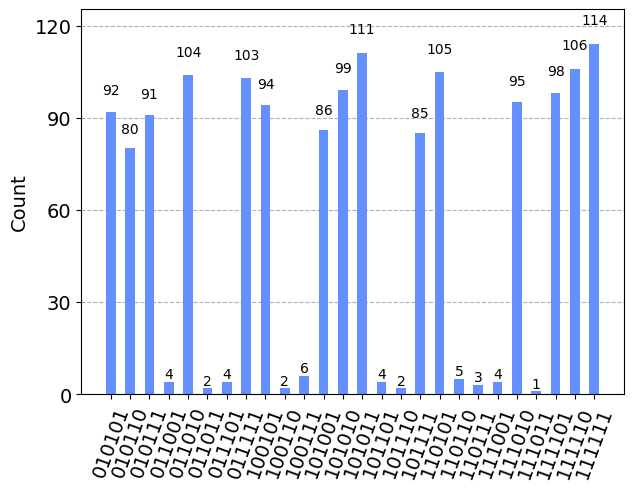

In [5]:
edges = [(1,2), (2,3)]
n = 3
trials = 1500
counts = three_coloring_grovers(edges, n, trials, N=2)
plot_histogram(counts)

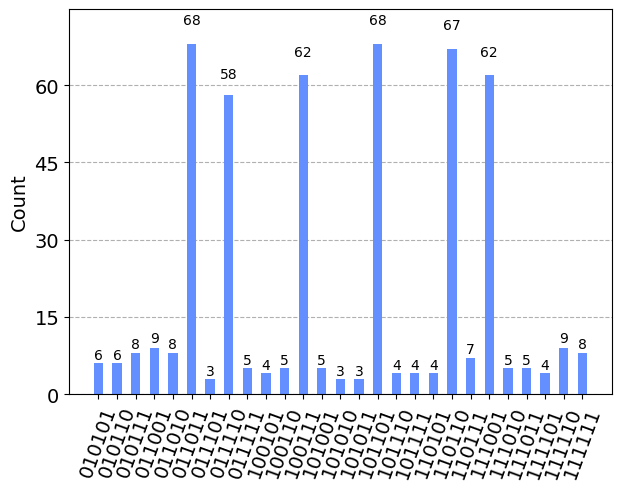

In [6]:
edges = [(1,2), (2,3), (1,3)]
n = 3
trials = 500
counts = three_coloring_grovers(edges, n, trials)
plot_histogram(counts)

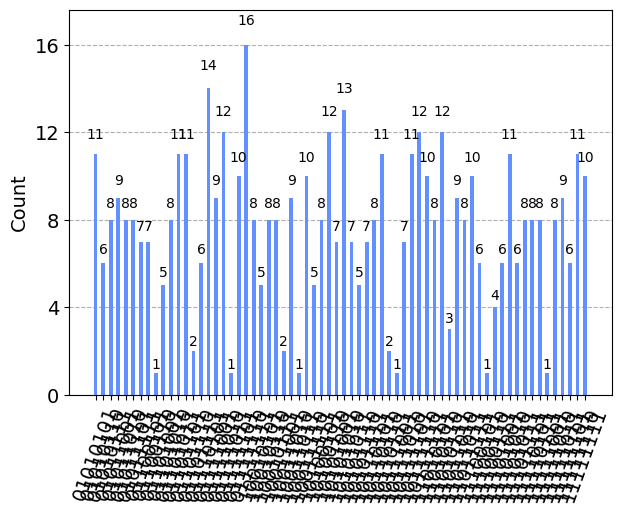

In [7]:
edges = [(1,2), (2,3), (1,4)]
n = 4
trials = 500
counts = three_coloring_grovers(edges, n, trials)
plot_histogram(counts)